In [1]:
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import interpolate as interp
import glob
from numpy.fft import ifft,fftshift
import matplotlib.pyplot as plt
import os

In [2]:
def extract_static(target_idx):

    # 获取所有文件名
    h_file_list = glob.glob(f"F:\\cherium\\Desktop\\Dataset\\StaticData\\{target_idx}\\H_*.csv")
    v_file_list = glob.glob(f"F:\\cherium\\Desktop\\Dataset\\StaticData\\{target_idx}\\V_*.csv")

    # # 初始化频率和角度矩阵
    frequencies = np.arange(9e9, 11e9 + 0.01e9, 0.01e9)
    first_file = pd.read_csv(h_file_list[0])
    theta = first_file['Theta']  # 获取角度列的长度
    theta_len = theta.shape[0]

    # # 初始化f * theta的矩阵
    Ephi_H = np.zeros((len(frequencies), theta_len), dtype=complex)
    Etheta_H = np.zeros((len(frequencies), theta_len), dtype=complex)
    Etheta_V = np.zeros((len(frequencies), theta_len), dtype=complex)
    Ephi_V = np.zeros((len(frequencies), theta_len), dtype=complex)

    for idx, filename in enumerate(h_file_list):
        data = pd.read_csv(filename)
        Ephi_H[idx, :] = data["Re(Ephi)"].values + 1j * data["Im(Ephi)"].values
        Etheta_H[idx, :] = data["Re(Etheta)"].values + 1j * data["Im(Etheta)"].values


    for idx, filename in enumerate(v_file_list):
        data = pd.read_csv(filename)
        Ephi_V[idx, :] = data["Re(Ephi)"].values + 1j * data["Im(Ephi)"].values
        Etheta_V[idx, :] = data["Re(Etheta)"].values + 1j * data["Im(Etheta)"].values

    static_hrrp = {
        "HH": Ephi_H,
        "HV": Etheta_H,
        "VV": Etheta_V,
        "VH": Ephi_V,
    }
    return static_hrrp, theta, frequencies
    
def create_interpolation_functions(theta, static_hrrp):
    interpolation_functions_real = []
    interpolation_functions_imag = []
    
    for row in static_hrrp:
        real_part = row.real
        imag_part = row.imag
        
        interp_func_real = interp.interp1d(theta, real_part, kind='cubic')
        interp_func_imag = interp.interp1d(theta, imag_part, kind='cubic')
        
        interpolation_functions_real.append(interp_func_real)
        interpolation_functions_imag.append(interp_func_imag)
        
    return interpolation_functions_real, interpolation_functions_imag


def dynamic_hrrp(interpolation_functions_real, interpolation_functions_imag, angles):
    angles = np.array(angles)
    dynamic_hrrp_matrix = np.zeros((len(interpolation_functions_real), len(angles)), dtype=complex)
    
    for i, (interp_func_real, interp_func_imag) in enumerate(zip(interpolation_functions_real, interpolation_functions_imag)):
        real_part = interp_func_real(angles)
        imag_part = interp_func_imag(angles)
        
        dynamic_hrrp_matrix[i, :] = real_part + 1j * imag_part
    return dynamic_hrrp_matrix


def create_interpolation_dict(static_hrrp, theta):
    if static_hrrp is None:
        return None
    
    theta = theta.unique()

    interpolation_dict = {}
    for key, static_field in static_hrrp.items():
        interp_funcs_real, interp_funcs_imag = create_interpolation_functions(theta, static_field)
        interpolation_dict[key] = (interp_funcs_real, interp_funcs_imag)
    return interpolation_dict


def extract_hrrp(interpolation_dict, los_angles):
    if interpolation_dict is None:
        return None

    pol_hrrp = {}
    for key, (interp_funcs_real, interp_funcs_imag) in interpolation_dict.items():
        pol_hrrp[key] = dynamic_hrrp(interp_funcs_real, interp_funcs_imag, los_angles)
    return pol_hrrp

(50.0, 150.0)

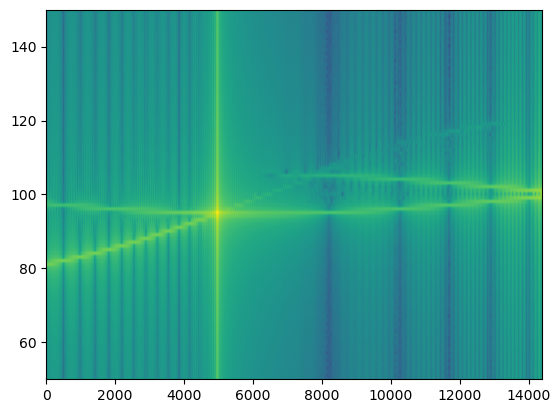

In [3]:
target_idx = 0

# 定义频率范围和步长
start_freq = 9e9  # 起始频率 9 GHz
end_freq = 11e9   # 结束频率 11 GHz
step = 0.01e9     # 步长 0.01 GHz

# 获取所有文件名
h_file_list = glob.glob(f"F:\\cherium\\Desktop\\Dataset\\StaticData\\{target_idx}\\H_*.csv")
v_file_list = glob.glob(f"F:\\cherium\\Desktop\\Dataset\\StaticData\\{target_idx}\\V_*.csv")

# # 初始化频率和角度矩阵
frequencies = np.arange(9e9, 11e9 + 0.01e9, 0.01e9)
first_file = pd.read_csv(h_file_list[0])
theta = first_file['Theta']  # 获取角度列的长度
theta_len = theta.shape[0]

# # 初始化f * theta的矩阵
Ephi_H = np.zeros((len(frequencies), theta_len), dtype=complex)
Etheta_H = np.zeros((len(frequencies), theta_len), dtype=complex)
Etheta_V = np.zeros((len(frequencies), theta_len), dtype=complex)
Ephi_V = np.zeros((len(frequencies), theta_len), dtype=complex)

for idx, filename in enumerate(h_file_list):
    data = pd.read_csv(filename)
    Ephi_H[idx, :] = data["Re(Ephi)"].values + 1j * data["Im(Ephi)"].values
    Etheta_H[idx, :] = data["Re(Etheta)"].values + 1j * data["Im(Etheta)"].values


for idx, filename in enumerate(v_file_list):
    data = pd.read_csv(filename)
    Ephi_V[idx, :] = data["Re(Ephi)"].values + 1j * data["Im(Ephi)"].values
    Etheta_V[idx, :] = data["Re(Etheta)"].values + 1j * data["Im(Etheta)"].values

static_hrrp = {
    "HH": Ephi_H,
    "HV": Etheta_H,
    "VV": Etheta_V,
    "VH": Ephi_V,
}

hrrp = fftshift(ifft(Ephi_H,axis = 0),axes=0)
hrrp = np.log10(np.abs(hrrp))

plt.imshow(hrrp, aspect='auto')
plt.ylim(50,150)

In [4]:
# 预处理数据

test_dir = './train/0/0.pkl'

with open(test_dir, 'rb') as file:
    instance = pickle.load(file)

target_idx = instance['target_id']


static_hrrp, theta, frequencies = extract_static(target_idx)
# # 使用tqdm监视循环进度

try:
    with open(test_dir, 'rb') as file:
        instance = pickle.load(file)
    if instance['hrrp'] is None:
        target_idx = instance['target_id']
        los_angles = instance['los']

        interpolation_dict = create_interpolation_dict(static_hrrp, theta)  
        hrrp_values = extract_hrrp(interpolation_dict, los_angles)
        
        instance['hrrp'] = hrrp_values

        with open(test_dir, 'wb') as file:
            pickle.dump(instance, file)


except Exception as e:
    print(f'error occured on {e} when dealing instance {test_dir}')

In [6]:
with open(test_dir, 'rb') as file:
    instance = pickle.load(file)

(50.0, 150.0)

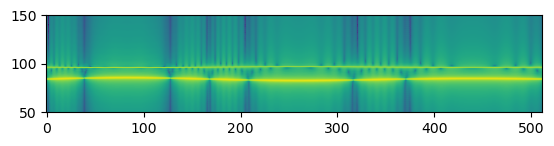

In [11]:
hrrp = instance['hrrp']['HH']
hrrp = fftshift(ifft(hrrp,axis = 0),axes=0)
hrrp = np.log10(np.abs(hrrp))

plt.imshow(hrrp)
plt.ylim([50,150])